In [42]:
import matplotlib.pyplot as plt
import networkx as nx

In [1]:
import pyreadr
train_normal_path = 'TEP2017R/TEP_FaultFree_Training.RData'
train_faulty_path =  'TEP2017R/TEP_Faulty_Training.RData'
 
test_normal_path = 'TEP2017R/TEP_FaultFree_Testing.RData'
test_faulty_path = 'TEP2017R/TEP_Faulty_Testing.RData'
 
train_normal = pyreadr.read_r(train_normal_path)['fault_free_training']
train_faulty = pyreadr.read_r(train_faulty_path)['faulty_training']
test_normal = pyreadr.read_r(test_normal_path)['fault_free_testing']
test_faulty = pyreadr.read_r(test_faulty_path)['faulty_testing']
df_train_normal = train_normal[train_normal.simulationRun==1].iloc[:,3:]

In [38]:
df_train_normal.head()

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,74.863,120.41,0.33818,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,75.000,120.41,0.33620,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,74.771,120.42,0.33563,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,75.224,120.39,0.33553,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,75.388,120.39,0.32632,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


In [10]:
# PCA
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=2)
x = StandardScaler().fit_transform(df_train_normal)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

In [32]:
name = list(df_train_normal.columns)
score = abs(pca.components_)
print(sorted(zip(score[0], name), reverse=True)[:5])
print(sorted(zip(score[1], name), reverse=True)[:5])

[(0.3458369064787039, 'xmeas_13'), (0.3446001237974229, 'xmeas_7'), (0.33017298242549814, 'xmeas_16'), (0.2910754520953006, 'xmv_5'), (0.2553326919345332, 'xmeas_20')]
[(0.3734306392025106, 'xmv_9'), (0.37331386474514056, 'xmeas_19'), (0.36408108116496773, 'xmeas_18'), (0.26167116131092133, 'xmeas_20'), (0.2509693887512119, 'xmeas_29')]


In [29]:
print(pca.explained_variance_ratio_)

[0.14261039 0.09379146]


In [49]:
# Bayesian
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch
from pgmpy.models import BayesianNetwork

In [45]:
"""
# Funtion to evaluate the learned model structures. Not useful since we don't know the actual structure.
def get_f1_score(estimated_model, true_model):
    nodes = estimated_model.nodes()
    est_adj = nx.to_numpy_array(
        estimated_model.to_undirected(), nodelist=nodes, weight=None
    )
    true_adj = nx.to_numpy_array(
        true_model.to_undirected(), nodelist=nodes, weight=None
    )

    f1 = f1_score(np.ravel(true_adj), np.ravel(est_adj))
    print("F1-score for the model skeleton: ", f1)
est = PC(data=df_train_normal)
estimated_model = est.estimate(variant="stable", max_cond_vars=4)
get_f1_score(estimated_model, model)
"""

'\n# Funtion to evaluate the learned model structures. Not useful since we don\'t know the actual structure.\ndef get_f1_score(estimated_model, true_model):\n    nodes = estimated_model.nodes()\n    est_adj = nx.to_numpy_array(\n        estimated_model.to_undirected(), nodelist=nodes, weight=None\n    )\n    true_adj = nx.to_numpy_array(\n        true_model.to_undirected(), nodelist=nodes, weight=None\n    )\n\n    f1 = f1_score(np.ravel(true_adj), np.ravel(est_adj))\n    print("F1-score for the model skeleton: ", f1)\nest = PC(data=df_train_normal)\nestimated_model = est.estimate(variant="stable", max_cond_vars=4)\nget_f1_score(estimated_model, model)\n'

Building tree:   0%|          | 0/1326.0 [00:00<?, ?it/s]

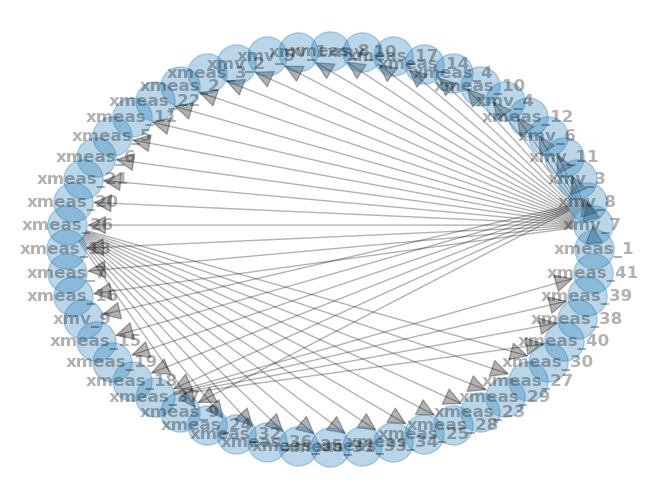

In [47]:
from pgmpy.estimators import TreeSearch

# learn graph structure
est = TreeSearch(df_train_normal, root_node="xmeas_1")
dag = est.estimate(estimator_type="chow-liu")
nx.draw_circular(
    dag, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
)
plt.show()

In [51]:
from pgmpy.estimators import BayesianEstimator

# there are many choices of parametrization, here is one example
model = BayesianNetwork(dag.edges())
model.fit(
    df_train_normal, estimator=BayesianEstimator, prior_type="dirichlet", pseudo_counts=0.1
)
model.get_cpds()

[<TabularCPD representing P(xmeas_1:482) at 0x1db1432ef50>,
 <TabularCPD representing P(xmv_7:490 | xmeas_1:482) at 0x1db14600a50>,
 <TabularCPD representing P(xmv_8:490 | xmv_7:490) at 0x1db149049d0>,
 <TabularCPD representing P(xmv_3:488 | xmv_7:490) at 0x1db149076d0>,
 <TabularCPD representing P(xmv_11:479 | xmv_7:490) at 0x1db149048d0>,
 <TabularCPD representing P(xmv_6:473 | xmv_7:490) at 0x1db14905650>,
 <TabularCPD representing P(xmeas_12:462 | xmv_7:490) at 0x1db14905750>,
 <TabularCPD representing P(xmv_4:471 | xmv_7:490) at 0x1db14905b90>,
 <TabularCPD representing P(xmeas_10:462 | xmv_7:490) at 0x1db14906050>,
 <TabularCPD representing P(xmeas_4:460 | xmv_7:490) at 0x1db149062d0>,
 <TabularCPD representing P(xmeas_14:455 | xmv_7:490) at 0x1db149065d0>,
 <TabularCPD representing P(xmeas_17:451 | xmv_7:490) at 0x1db14906990>,
 <TabularCPD representing P(xmv_10:446 | xmv_7:490) at 0x1db14906d90>,
 <TabularCPD representing P(xmeas_8:441 | xmv_7:490) at 0x1db14907450>,
 <TabularC